In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_excel('data_with_distances.xlsx')

# Select features and target
selected_features = ['InfoVeranstaltung', 'Distance_to_71034', 'Note Bachelor', 
                     'Zweitbewerbung', 'Fachrichtung Bachelor', 'Note HZB']
X = data[selected_features]
y = data['Immatrikulation']

# Identify categorical and numerical columns
categorical_features = ['InfoVeranstaltung', 'Zweitbewerbung', 'Fachrichtung Bachelor']
numerical_features = ['Distance_to_71034', 'Note Bachelor', 'Note HZB']

# Create preprocessing steps
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "LightGBM": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        "accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(results[name]["classification_report"])
    print("Confusion Matrix:")
    print(results[name]["confusion_matrix"])
    
    # Plot feature importance
    if hasattr(model[-1], 'feature_importances_'):
        importances = model[-1].feature_importances_
        feature_names = numerical_features + [f"{feat}_{cat}" for feat, cats in zip(categorical_features, model[0].named_transformers_['cat'].categories_) for cat in cats[1:]]
    elif hasattr(model[-1], 'coef_'):
        importances = np.abs(model[-1].coef_[0])
        feature_names = numerical_features + [f"{feat}_{cat}" for feat, cats in zip(categorical_features, model[0].named_transformers_['cat'].categories_) for cat in cats[1:]]
    else:
        print(f"Feature importance not available for {name}")
        continue
    
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'{name} Feature Importances')
    plt.tight_layout()
    plt.show()

# Compare models using cross-validation
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    cv_scores[name] = scores.mean()

plt.figure(figsize=(10, 6))
plt.bar(cv_scores.keys(), cv_scores.values())
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\nCross-Validation Scores:")
for name, score in cv_scores.items():
    print(f"{name}: {score:.4f}")


Random Forest Results:
Accuracy: 0.8500
Classification Report:
              precision    recall  f1-score   support

          Ja       0.79      1.00      0.88        11
        Nein       1.00      0.67      0.80         9

    accuracy                           0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20

Confusion Matrix:
[[11  0]
 [ 3  6]]


c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


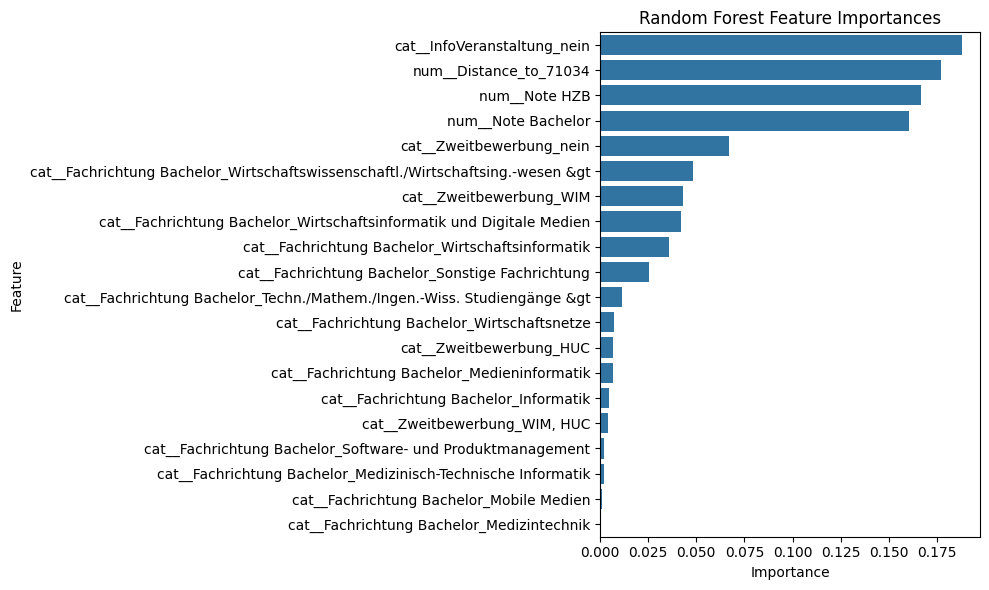

c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Number of positive: 32, number of negative: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.421053 -> initscore=-0.318454
[LightGBM] [Info] Start training from score -0.318454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

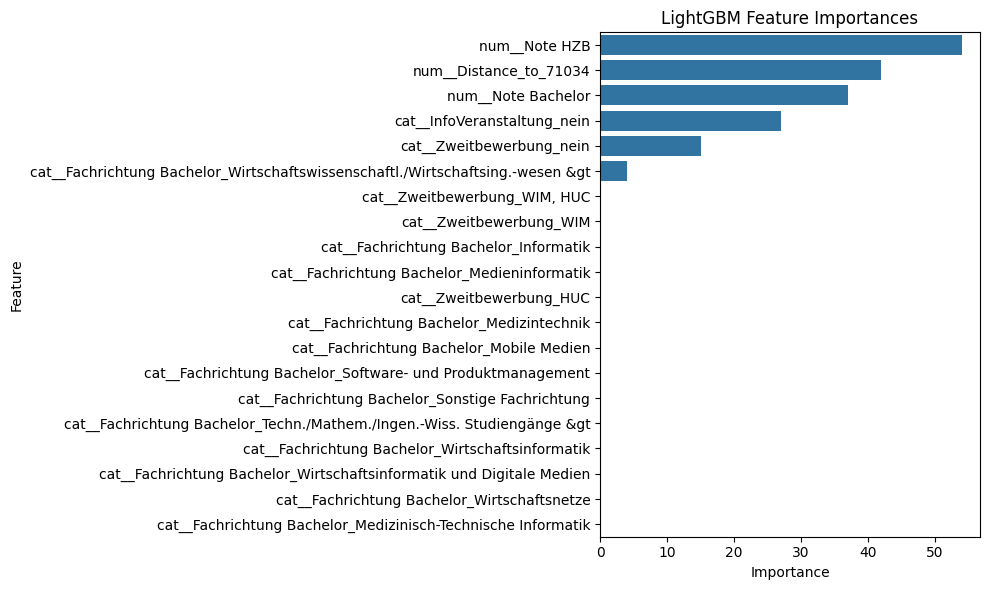

c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Logistic Regression Results:
Accuracy: 0.8000
Classification Report:
              precision    recall  f1-score   support

          Ja       0.73      1.00      0.85        11
        Nein       1.00      0.56      0.71         9

    accuracy                           0.80        20
   macro avg       0.87      0.78      0.78        20
weighted avg       0.85      0.80      0.79        20

Confusion Matrix:
[[11  0]
 [ 4  5]]


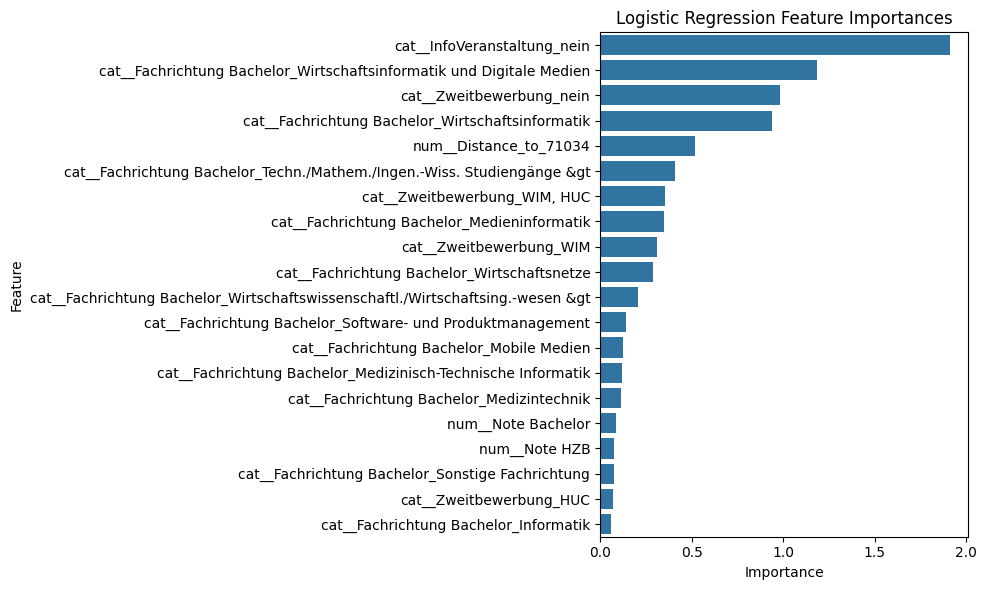

c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Info] Number of positive: 32, number of negative: 44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.421053 -> initscore=-0.318454
[LightGBM] [Info] Start training from score -0.318454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Herby\.conda\envs\py12-PO\Lib\site-packages\s

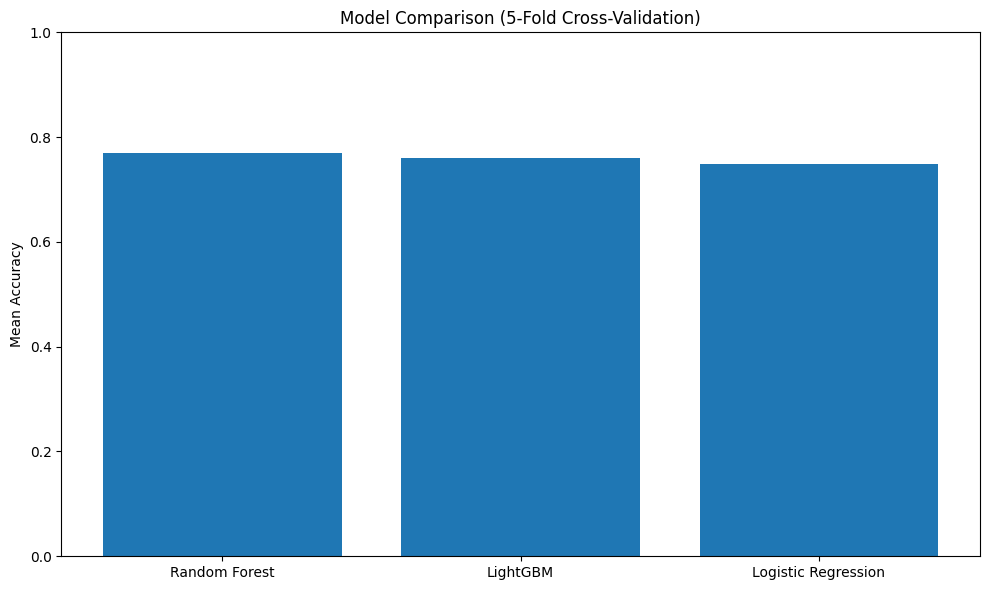


Cross-Validation Scores:
Random Forest: 0.7700
LightGBM: 0.7600
Logistic Regression: 0.7489


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_excel('data_with_distances.xlsx')

# Select features and target
selected_features = ['InfoVeranstaltung', 'Distance_to_71034', 'Note Bachelor', 
                     'Zweitbewerbung', 'Fachrichtung Bachelor', 'Note HZB']
X = data[selected_features]
y = data['Immatrikulation']

# Identify categorical and numerical columns
categorical_features = ['InfoVeranstaltung', 'Zweitbewerbung', 'Fachrichtung Bachelor']
numerical_features = ['Distance_to_71034', 'Note Bachelor', 'Note HZB']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    "LightGBM": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        "accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(results[name]["classification_report"])
    print("Confusion Matrix:")
    print(results[name]["confusion_matrix"])
    
    # Plot feature importance
    if hasattr(model[-1], 'feature_importances_'):
        importances = model[-1].feature_importances_
        feature_names = model[0].get_feature_names_out()
    elif hasattr(model[-1], 'coef_'):
        importances = np.abs(model[-1].coef_[0])
        feature_names = model[0].get_feature_names_out()
    else:
        print(f"Feature importance not available for {name}")
        continue
    
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'{name} Feature Importances')
    plt.tight_layout()
    plt.show()

# Compare models using cross-validation
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5)
    cv_scores[name] = scores.mean()

plt.figure(figsize=(10, 6))
plt.bar(cv_scores.keys(), cv_scores.values())
plt.title('Model Comparison (5-Fold Cross-Validation)')
plt.ylabel('Mean Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print("\nCross-Validation Scores:")
for name, score in cv_scores.items():
    print(f"{name}: {score:.4f}")